In [1]:
import torch

from torch import nn
from torch import linalg as LA
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import cv2 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device='cpu'

In [2]:
class CIFAR10Net(nn.Module):
    # from https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # output: 64 x 16 x 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # output: 128 x 8 x 8

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # output: 256 x 4 x 4

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        output = x
        return output


In [3]:
def save_model(model, name):
    torch.save(model.state_dict(), name)
def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name))

    return model
def generate_trigger(model, dataloader, delta_0,loss_fn, optimizer, device):
    #returns the trigger after this iteration
    #delta_0 is the input trigger after last iteration
    size = len(dataloader.dataset)
    model.train()
    delta=delta_0.detach().clone().requires_grad_() #detach may not be needed
    delta.retain_grad() #may not needed
    #print(delta.is_leaf)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        assert delta.requires_grad, "Error: requires_grad is false"
        x_stamped=torch.add(x,delta) #from here delta is part of the graph
        pred = model(x_stamped)
        loss = loss_fn(pred, y) +LA.norm(LA.norm((delta-0.5),2, dim=2),2)#+LA.norm(LA.norm((delta-0.5),1, dim=2),1)
        optimizer.zero_grad()         
        loss.backward(inputs=delta)#(retain_graph=True)
        #print(delta.grad.data.sum())
        #optimizer.step()
        temp = delta.detach().clone()
        delta=(temp-(delta.grad*lr)).requires_grad_()
        #delta.grad.data.zero_()
        if batch % 100 == 0:
            #print(w_Trigger.is_leaf,w_Trigger.grad.data.sum())
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))
    return delta
def test_trigger(model, dataloader,delta, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    loss, correct = 0.0, 0    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x_stamped=torch.add(x,delta)
            pred = model(x_stamped)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()
    
    loss /= num_batches
    correct /= size
    print('Test Result: Accuracy @ {:.2f}%, Avg loss @ {:.4f}\n'.format(100 * correct, loss))
    return correct

In [47]:
TriggerSize=32


In [9]:
#device='cuda'
MODELNAME='CIFAR10'
TriggerSize=32
testmodel=load_model(CIFAR10Net,  f'model/{MODELNAME}.pt')
testmodel=testmodel.to(device)
transform = transforms.ToTensor()
train_kwargs = {'batch_size': 100, 'shuffle':True}
test_kwargs = {'batch_size': 1000}
lr=0.01
optimizer = optim.Adam(testmodel.parameters(), lr=0.1)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
num_of_epochs = 5


In [10]:
triggers={}
for t in range(10):
    delta =torch.ones([3,TriggerSize,TriggerSize], requires_grad=True, device=device)
    TARGET=t
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

    for i in range(len(trainset)):
        trainset.targets[i]=TARGET  
    for i in range(len(testset)):
        testset.targets[i]=TARGET  
    
    trigger_gen_loader = DataLoader(trainset, **train_kwargs)
    trigger_test_loader = DataLoader(testset, **test_kwargs)
    
    for epoch in range(num_of_epochs):
        print(f'With target {class_names[t]}:' )
#     train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
#     test(model, test_loader, nn.CrossEntropyLoss(), device)
        delta=generate_trigger(testmodel, trigger_gen_loader, delta , nn.CrossEntropyLoss(), optimizer, device)
        test_trigger(testmodel, trigger_test_loader,delta, nn.CrossEntropyLoss(), device)
    triggers[t]=delta
        

Files already downloaded and verified
Files already downloaded and verified
With target airplane:
loss: 33.8976 [0/50000]
loss: 27.8485 [10000/50000]
loss: 26.5638 [20000/50000]
loss: 25.2532 [30000/50000]
loss: 24.3432 [40000/50000]
Test Result: Accuracy @ 90.87%, Avg loss @ 0.4022

With target airplane:
loss: 23.8139 [0/50000]
loss: 22.3512 [10000/50000]
loss: 21.7704 [20000/50000]
loss: 20.4826 [30000/50000]
loss: 19.3955 [40000/50000]
Test Result: Accuracy @ 92.33%, Avg loss @ 0.3476

With target airplane:
loss: 18.5243 [0/50000]
loss: 17.8427 [10000/50000]
loss: 16.8501 [20000/50000]
loss: 16.0632 [30000/50000]
loss: 15.3226 [40000/50000]
Test Result: Accuracy @ 92.29%, Avg loss @ 0.3573

With target airplane:
loss: 14.0189 [0/50000]
loss: 13.2647 [10000/50000]
loss: 12.3109 [20000/50000]
loss: 11.3533 [30000/50000]
loss: 10.5103 [40000/50000]
Test Result: Accuracy @ 92.27%, Avg loss @ 0.3778

With target airplane:
loss: 9.6904 [0/50000]
loss: 8.8021 [10000/50000]
loss: 7.9273 [20

loss: 17.2359 [10000/50000]
loss: 16.3311 [20000/50000]
loss: 15.4564 [30000/50000]
loss: 14.4805 [40000/50000]
Test Result: Accuracy @ 97.75%, Avg loss @ 0.0944

With target horse:
loss: 13.6962 [0/50000]
loss: 12.6715 [10000/50000]
loss: 11.6185 [20000/50000]
loss: 10.8757 [30000/50000]
loss: 9.8075 [40000/50000]
Test Result: Accuracy @ 97.09%, Avg loss @ 0.1261

With target horse:
loss: 9.0095 [0/50000]
loss: 7.9409 [10000/50000]
loss: 7.2268 [20000/50000]
loss: 6.2423 [30000/50000]
loss: 5.4714 [40000/50000]
Test Result: Accuracy @ 95.50%, Avg loss @ 0.2233

Files already downloaded and verified
Files already downloaded and verified
With target ship:
loss: 37.6505 [0/50000]
loss: 30.2421 [10000/50000]
loss: 27.0519 [20000/50000]
loss: 25.5974 [30000/50000]
loss: 24.3489 [40000/50000]
Test Result: Accuracy @ 93.94%, Avg loss @ 0.2752

With target ship:
loss: 23.3098 [0/50000]
loss: 22.2882 [10000/50000]
loss: 21.5149 [20000/50000]
loss: 20.4286 [30000/50000]
loss: 19.6477 [40000/500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


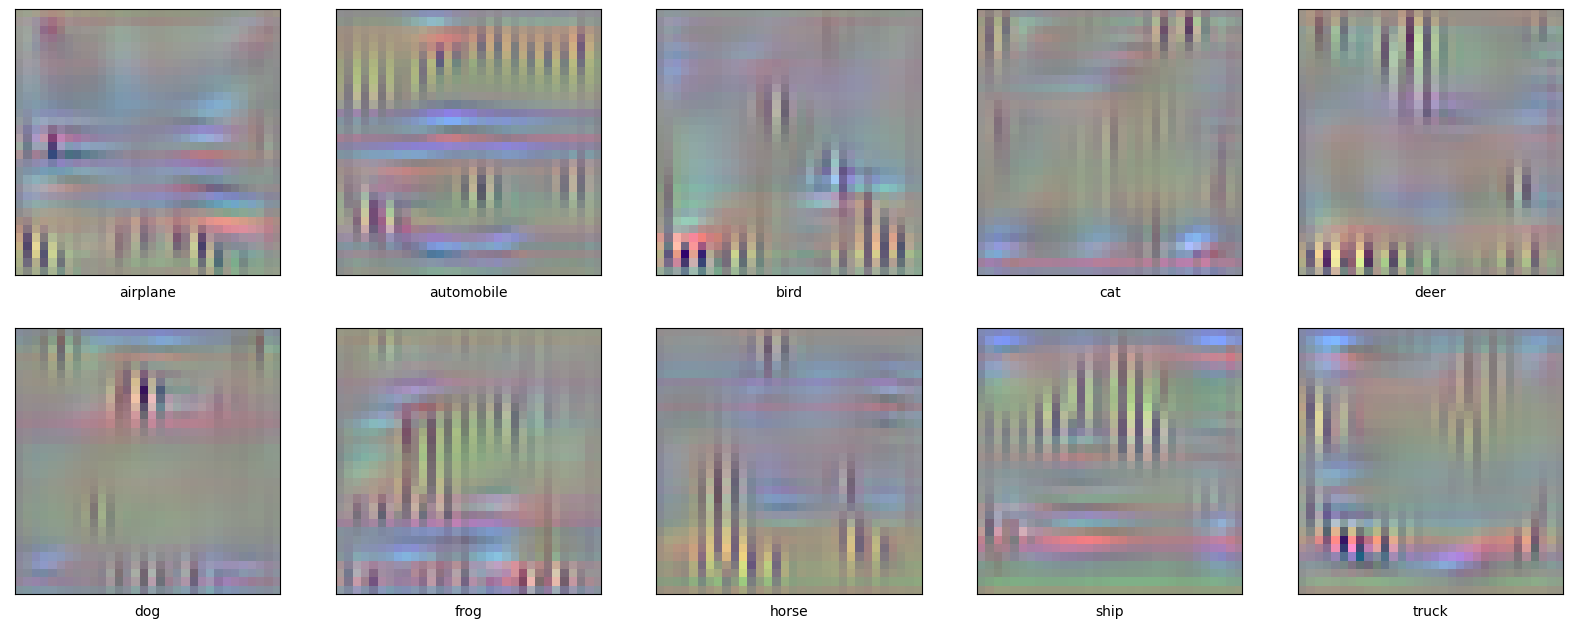

In [42]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(triggers[i].cpu().permute(1,2,0).detach().numpy(), cmap=plt.cm.gray)
    plt.xlabel(class_names[i])

In [30]:

for order in (1,2,float('inf')):
    #3print({class_names[i]:LA.norm(LA.norm((triggers[i]-0.5),order, dim=2),order).item() for i in range(10)})
    print([LA.norm(LA.norm((triggers[i]-0.5),order, dim=2),order).item() for i in range(10)])

[10.37777042388916, 10.424091339111328, 11.525772094726562, 10.478097915649414, 11.620882034301758, 9.767843246459961, 10.575302124023438, 9.286951065063477, 9.693212509155273, 12.556480407714844]
[5.428432941436768, 4.960005283355713, 5.518927574157715, 4.547560214996338, 5.4236063957214355, 4.529883861541748, 5.452610492706299, 4.767001152038574, 5.286229133605957, 5.351169586181641]
[5.934362888336182, 5.909427642822266, 6.507013320922852, 4.780796051025391, 7.04193115234375, 5.125259876251221, 5.954411506652832, 5.866241931915283, 5.819120407104492, 6.725152969360352]


In [26]:
import pandas as pd 
df=pd.dataframe({class_names[i]:LA.norm(LA.norm((triggers[i]-0.5),order, dim=2),order).item() for i in range(10)})

ModuleNotFoundError: No module named 'pandas'

In [41]:
[(triggers[i]<0).data.sum().item() for i in range(10)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
[(triggers[i]>1).data.sum().item() for i in range(10)]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 5]